In [26]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

df_train = pd.read_csv('../data/diabetes_train.csv') 
df_test = pd.read_csv('../data/diabetes_test.csv')

TARGET_COL = 'Diabetes'

Calculando validación cruzada para learning_rate=0.005...
Calculando validación cruzada para learning_rate=0.01...
Calculando validación cruzada para learning_rate=0.02...
Calculando validación cruzada para learning_rate=0.05...
Calculando validación cruzada para learning_rate=0.1...


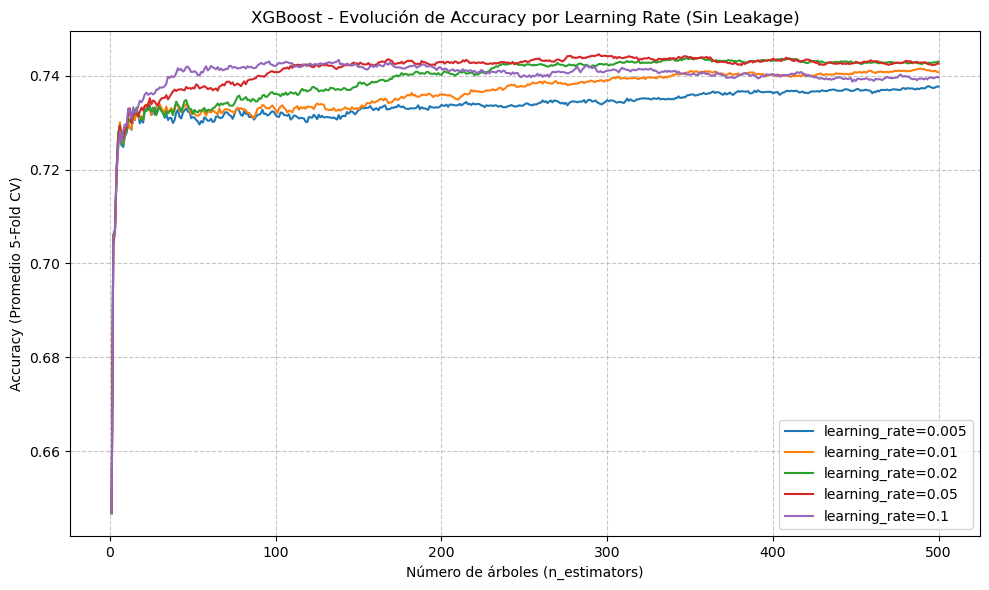

In [20]:
# 1. Visualizamos el efecto del learning rate y cuantas iteraciones necesitamos (usamos solo entrenamiento)

X_cv = df_train.drop(columns=[TARGET_COL])
y_cv = df_train[TARGET_COL].replace({2: 1}) # XGBoost requiere 0 y 1 (como la clase diabetico es 2)

# 2. Configuración de parámetros
num_features = X_cv.shape[1]
colsample_bynode = np.sqrt(num_features) / num_features # Simula sqrt típico usado en Random Forest
learning_rates = [0.005,0.01,0.02, 0.05,0.1] #distintos números a probar
n_estimators_max = 500  # Máximo de árboles a probar

plt.figure(figsize=(10, 6))

# Convertimos a DMatrix una sola vez para máxima velocidad
dtrain = xgb.DMatrix(X_cv, label=y_cv)

for lr in learning_rates:
    print(f"Calculando validación cruzada para learning_rate={lr}...")
    
    params = {
        'max_depth': 3, #he probado tb con 3 
        'learning_rate': lr,
        'subsample': 0.9,
        'colsample_bynode': colsample_bynode,
        'objective': 'binary:logistic',
        'eval_metric': 'error', # Error = 1 - Accuracy
        'nthread': -1
    }
    
    # Ejecutamos la Validación Cruzada (K-Fold)
    cv_history = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators_max,
        nfold=5,             # 5-Fold CV
        stratified=True,
        as_pandas=True,
        seed=42
    )
    
    # Convertimos el error medio de los folds a Accuracy
    acc_cv = 1 - cv_history['test-error-mean']
    
    # Graficamos la curva para este learning rate
    plt.plot(range(1, len(acc_cv) + 1), acc_cv, label=f'learning_rate={lr}')

# 3. Formato del gráfico
plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('Accuracy (Promedio 5-Fold CV)')
plt.title('XGBoost - Evolución de Accuracy por Learning Rate (Sin Leakage)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Se tiene un modelo que sobreajusta muy rápido, se ve con las learning rates más grandes que rápidamente alcanza el máximo y luego ya va bajando la accuracy cuanto más continúa aprendiendo el modelo. Con los rangos que aquí he estimado como que serán suficientes he diseñado el siguiente search Grid incluyendo tb parámetros de regularización más finos como los de regularización L1, L2. Va a realizarse randomized grid search pq si no tardaría demasiado. Es posible que no encontremos el máximo global pero todos serán muy parecidos y el objetivo de este trabajo es la interpretación.

COPIAR AQUÍ LO QUE PUSE EN MI TFG DE LO QUE SIGNIFICABAN LOS PARÁMETROS

In [24]:
# Definimos el espacio de búsqueda
param_dist = {
    # 1. Parámetros de Estructura (Controlan complejidad)
    'max_depth': [3, 5, 8],            # Evitamos ir a >10 por el tamaño del dataset
    'min_child_weight': [5, 10, 20],      # Cuanto más alto, más conservador (ideal para ese 2.5% raro)
    
    # 2. Parámetros de Robustez (Aleatoriedad para evitar memorización)
    'subsample': [0.8, 0.9],
    'colsample_bynode': [colsample_bynode,0.5,0.8],
    
    # 3. Parámetros de Regularización (Los "frenos" del modelo)
    'gamma': [0, 0.1, 0.2],  # Penaliza la creación de nuevos nodos
    'reg_alpha': [0, 0.1, 0.5],      # L1 (Lasso) - puede eliminar variables poco útiles
    'reg_lambda': [0.5, 1, 2],        # L2 (Ridge) - suaviza los pesos de las variables
    
    # 4. Velocidad de aprendizaje y cantidad de árboles
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [100, 500, 800]
}

# Configuramos el buscador
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=200,           # Prueba 50 combinaciones aleatorias (puedes subirlo a 100 si tienes tiempo)
    scoring='f1',        # O 'roc_auc' para maximizar la capacidad de distinción
    cv=5,                # 5-Fold Cross Validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ejecutamos la búsqueda (usando solo el set de entrenamiento)
random_search.fit(X_cv, y_cv)

print(f"Mejores parámetros encontrados: {random_search.best_params_}")
print(f"Mejor score de CV (F1): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Mejores parámetros encontrados: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.02, 'gamma': 0.2, 'colsample_bynode': np.float64(0.21821789023599236)}
Mejor score de CV (F1): 0.7541


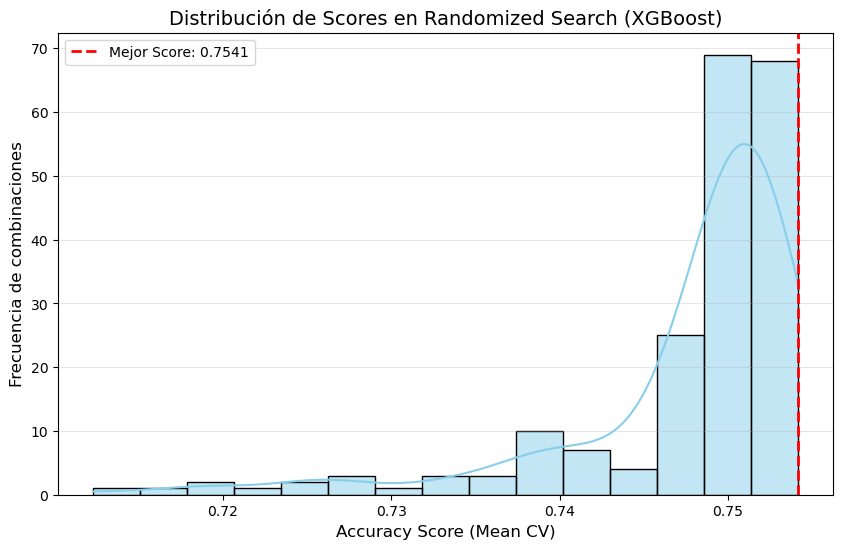

In [25]:
# --- VISUALIZACIÓN DE RESULTADOS ---

# Extraemos todos los scores medios de las 50 iteraciones
scores = random_search.cv_results_['mean_test_score']
best_score = random_search.best_score_

plt.figure(figsize=(10, 6))

# Creamos el histograma con la curva KDE
sns.histplot(scores, kde=True, color="skyblue", bins=15)

# Añadimos una línea vertical para el mejor resultado
plt.axvline(best_score, color='red', linestyle='--', linewidth=2, 
            label=f'Mejor Score: {best_score:.4f}')

plt.title(f'Distribución de Scores en Randomized Search (XGBoost)', fontsize=14)
plt.xlabel('Accuracy Score (Mean CV)', fontsize=12)
plt.ylabel('Frecuencia de combinaciones', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

Interpretar esto, hay dependencia de la combinación de hiperparámetros para obtener un rendimiento u otro, se ve con la forma de la distribución. Es vd q la mayoría de combinaciones se encuentran en torno al máximo obtenido, sin embargo tiene una larga cola hacia la izquierda, teniendose algunas pocas combinaciones que dan lugar a accuracys bastante menores. Vamos a aplicar ahora al conjunto de test y así vemos su capacidad de generalización realmente. 

--- REPORTE DE CLASIFICACIÓN FINAL (SET DE TEST) ---
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     42741
           1       0.33      0.79      0.47      7995

    accuracy                           0.72     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.72      0.75     50736



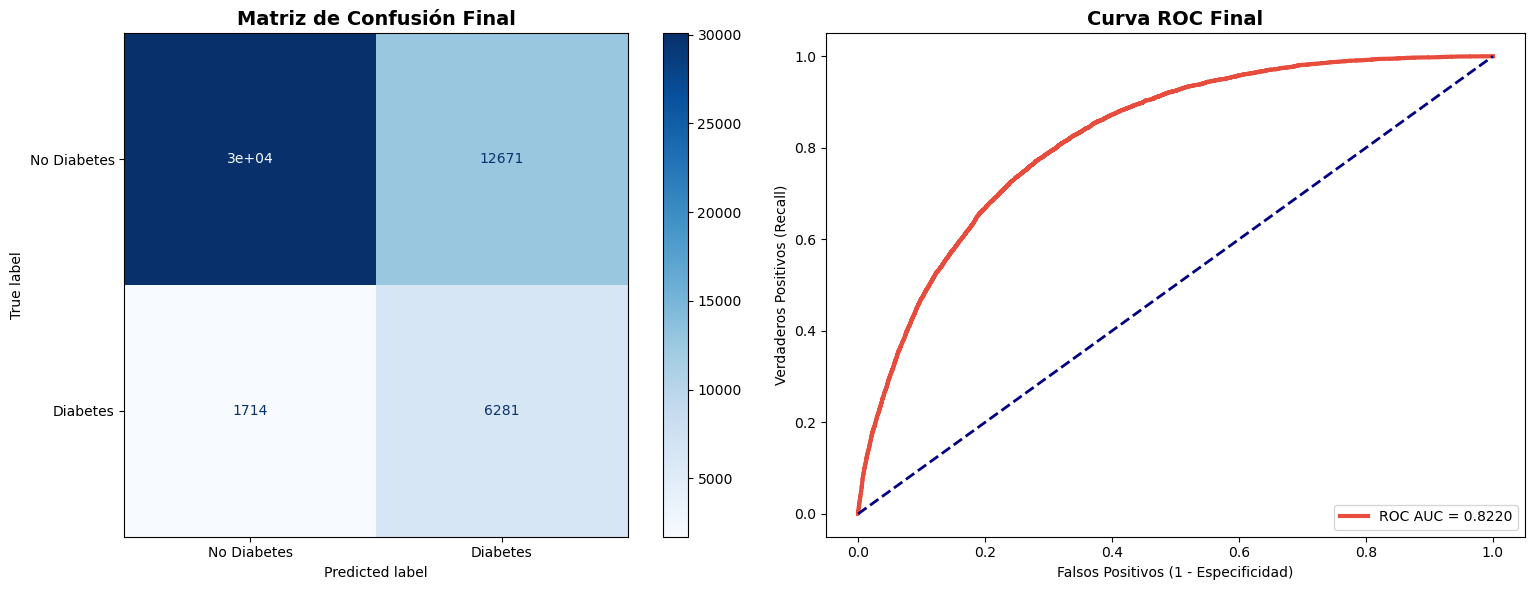

Área bajo la curva ROC (AUC): 0.8220


In [28]:
# 1. Extraer el mejor modelo del RandomizedSearch
best_xgb = random_search.best_estimator_

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL].replace({2: 1}) # XGBoost requiere 0 y 1 (como la clase diabetico es 2)

# 2. Realizar predicciones sobre el conjunto de TEST (el que no ha visto nunca)
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1] # Probabilidades para la curva ROC

# 3. Mostrar el reporte de clasificación detallado
print("--- REPORTE DE CLASIFICACIÓN FINAL (SET DE TEST) ---")
print(classification_report(y_test, y_pred))

# 4. Crear visualizaciones: Matriz de Confusión y Curva ROC
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# A. Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=['No Diabetes', 'Diabetes'], 
    cmap='Blues', 
    ax=ax[0]
)
ax[0].set_title('Matriz de Confusión Final', fontsize=14, weight='bold')

# B. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='#e74c3c', lw=3, label=f'ROC AUC = {roc_auc:.4f}')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_title('Curva ROC Final', fontsize=14, weight='bold')
ax[1].set_xlabel('Falsos Positivos (1 - Especificidad)')
ax[1].set_ylabel('Verdaderos Positivos (Recall)')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

print(f"Área bajo la curva ROC (AUC): {roc_auc_score(y_test, y_prob):.4f}")


Notar que estos resultados están bien desde el punto de vista médico porque es muy sensible a los diabéticos, de cada 100 diabéticos detecta 79, y cuando predice que no es diabético lo hace con una fiabilidad del 95%. Sin embargo cuando predice diabético habría que confirmarlo con un análisis de sangre u otro tipo de prueba (acierta sólo más o menos 1 de cada 3 veces, precisión clase positiva 0.33). Sin embargo esta situación es muy favorable para la prevención. 

Variables más relevantes según el modelo dataframe, filtrarlas mediante este criterio sería un filtrado de tipo embedded


C:\Users\usuario\AppData\Local\Temp\ipykernel_12916\3681731512.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


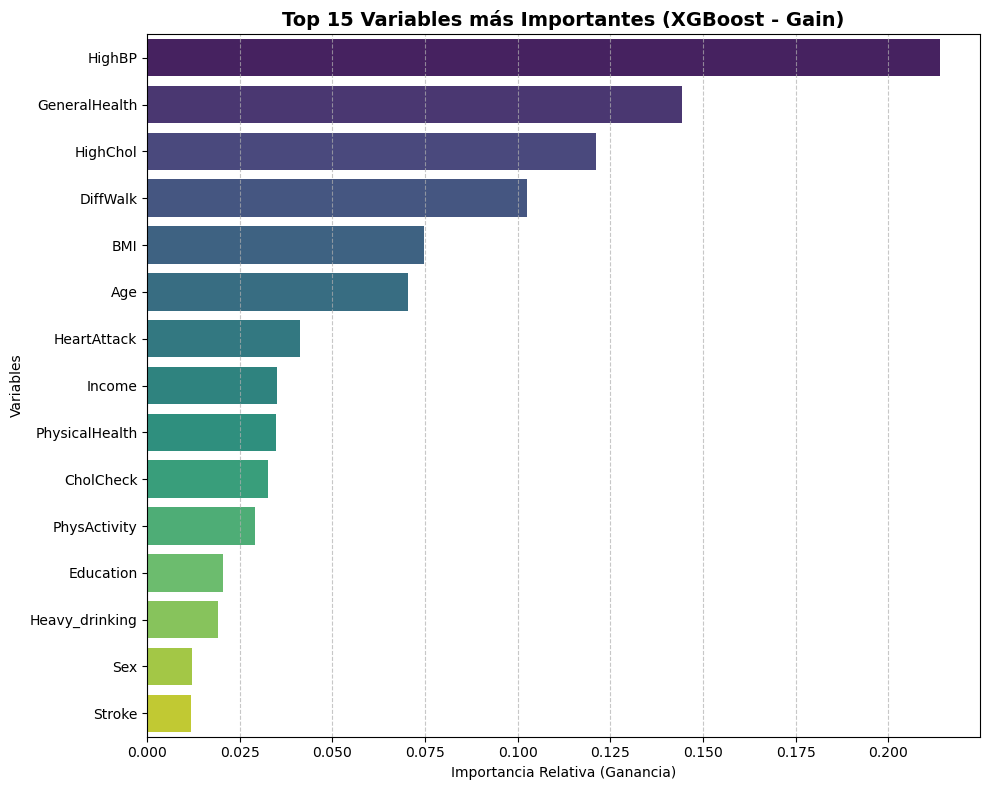

          Variable  Importancia
1           HighBP     0.213989
15   GeneralHealth     0.144252
2         HighChol     0.121153
13        DiffWalk     0.102501
0              BMI     0.074631
18             Age     0.070295
6      HeartAttack     0.041188
20          Income     0.035082
17  PhysicalHealth     0.034768
3        CholCheck     0.032576
7     PhysActivity     0.029018
19       Education     0.020411
10  Heavy_drinking     0.019240
14             Sex     0.012035
5           Stroke     0.011825


In [30]:
# 1. Extraer las importancias (Gain)
# 'best_xgb' es el modelo que salió de tu RandomizedSearchCV
importances = best_xgb.feature_importances_
feature_names = X_cv.columns

# 2. Crear un DataFrame para facilitar el manejo
feature_importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# 3. Graficar
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importancia', 
    y='Variable', 
    data=feature_importance_df.head(15), # Mostramos las 15 mejores
    palette='viridis'
)

plt.title('Top 15 Variables más Importantes (XGBoost - Gain)', fontsize=14, weight='bold')
plt.xlabel('Importancia Relativa (Ganancia)')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Opcional: imprimir el ranking por consola
print(feature_importance_df.head(15))

# INTERPRETABILITY (SHAP VALUES)